In [1]:
import os
import json
import numpy as np
from collections import defaultdict
import pprint
from nltk.translate.bleu_score import sentence_bleu

import matplotlib.pyplot as plt
%matplotlib inline

from collections import Counter

import nltk
from matplotlib.pyplot import figure

In [2]:
v0_out = '/root/data/home/hoyeung/blob_alfred_data/exp_all/model:seq2seq_nl_baseline,name:v0.5_epoch_50_high_level_instrs'
v1_out = '/root/data/home/hoyeung/blob_alfred_data/exp_all/model:seq2seq_nl_with_frames,name:v1.5_epoch_50_high_level_instrs'

In [3]:
epoch = 10

## Load debug data

In [4]:
path = os.path.join(v0_out, 'valid_seen_argmax.debug_epoch_{}.preds.json'.format(epoch))
with open(path, 'r') as f:
    v0_debug_valid_seen = json.load(f)
    
path = os.path.join(v0_out, 'valid_unseen_argmax.debug_epoch_{}.preds.json'.format(epoch))
with open(path, 'r') as f:
    v0_debug_valid_unseen = json.load(f)
    
path = os.path.join(v0_out, 'train_sanity_argmax.debug_epoch_{}.preds.json'.format(epoch))
with open(path, 'r') as f:
    v0_debug_train_sanity = json.load(f)
    

path = os.path.join(v1_out, 'valid_seen_argmax.debug_epoch_{}.preds.json'.format(epoch))
with open(path, 'r') as f:
    v1_debug_valid_seen = json.load(f)
    
path = os.path.join(v1_out, 'valid_unseen_argmax.debug_epoch_{}.preds.json'.format(epoch))
with open(path, 'r') as f:
    v1_debug_valid_unseen = json.load(f)
    
path = os.path.join(v1_out, 'train_sanity_argmax.debug_epoch_{}.preds.json'.format(epoch))
with open(path, 'r') as f:
    v1_debug_train_sanity = json.load(f)

In [5]:
def preprocess_debug_data(debug_dat):

	p_vocab = defaultdict(int)
	ref_vocab = defaultdict(int)

	task_ids = []
	n_ref_tokens_all = []
	n_pred_tokens_all = []
	n_subgoals_all = []
	n_actions_all = []

	ref_tokens_all = []
	p_tokens_all = []
    
	for task_id in debug_dat:

		task_ids.append(task_id)
		root = get_root_location(debug_dat[task_id]['root'])
		ref_instrs = get_ref_instrs(root)  # list of lists of tokens
		
		ref_tokens = [word for ref in ref_instrs for word in ref if word != '<<goal>>']
		p_tokens = debug_dat[task_id]['p_lang_instr'].split(' ')
        
		ref_tokens_all.extend(ref_tokens)
		p_tokens_all.extend(p_tokens*len(ref_instrs))
		
		n_ref_tokens = len(ref_tokens) * 1.0 /len(ref_instrs)
		n_pred_tokens = len(p_tokens)

		n_subgoals, n_actions = get_task_lengths(root)
		
		# write out
		for token in ref_tokens:
			ref_vocab[token] += 1
		for token in p_tokens:
			p_vocab[token] += 1
			
		n_ref_tokens_all.append(n_ref_tokens)
		n_pred_tokens_all.append(n_pred_tokens)
		n_subgoals_all.append(n_subgoals)
		n_actions_all.append(n_actions)
		
	return p_vocab, ref_vocab, p_tokens_all, ref_tokens_all, n_ref_tokens_all, n_pred_tokens_all, n_subgoals_all, n_actions_all, task_ids
	
    
    
def get_task_lengths(root):
    lang_goals = []
    lang_instrs = []
    path = os.path.join(root, 'pp', 'ann_%d.json' % 0)
    with open(path, 'r') as f:
        ex = json.load(f)
        action_low = [a['discrete_action']['action'] for a in ex['plan']['low_actions']]
        action_high = [a['discrete_action']['action'] for a in ex['plan']['high_pddl']]
    return len(action_high), len(action_low)  
	

def get_ref_instrs(root):
    flatten_isntr = lambda instr: [word.strip() for word in instr]
    ref_instrs = []
    for i in range(3):
        path = os.path.join(root, 'pp', 'ann_%d.json' % i)
        if os.path.exists(path):
            with open(path, 'r') as f:
                ex = json.load(f)
                ref_instrs.append(flatten_isntr(ex['ann']['goal']))
    return ref_instrs
	
	
def get_root_location(root):
    return root.replace('data/', '/root/data_alfred/')	

In [6]:
v1_train_sanity_p_vocab, _, v1_train_sanity_p_tokens,_,_,_,_,_,_ = preprocess_debug_data(v1_debug_train_sanity)
v0_train_sanity_p_vocab, ref_train_sanity_vocab, v0_train_sanity_p_tokens, train_sanity_ref_tokens ,_,_,_,_,_ = preprocess_debug_data(v0_debug_train_sanity)

In [7]:
v1_valid_seen_p_vocab, _, v1_valid_seen_p_tokens,_,_,_,_,_,_ = preprocess_debug_data(v1_debug_valid_seen)
v0_valid_seen_p_vocab, ref_valid_seen_vocab, v0_valid_seen_p_tokens, valid_seen_ref_tokens ,_,_,_,_,_ = preprocess_debug_data(v0_debug_valid_seen)

In [8]:
v1_valid_unseen_p_vocab, _, v1_valid_unseen_p_tokens,_,_,_,_,_,_ = preprocess_debug_data(v1_debug_valid_unseen)
v0_valid_unseen_p_vocab, ref_valid_unseen_vocab, v0_valid_unseen_p_tokens, valid_unseen_ref_tokens ,_,_,_,_,_ = preprocess_debug_data(v0_debug_valid_unseen)

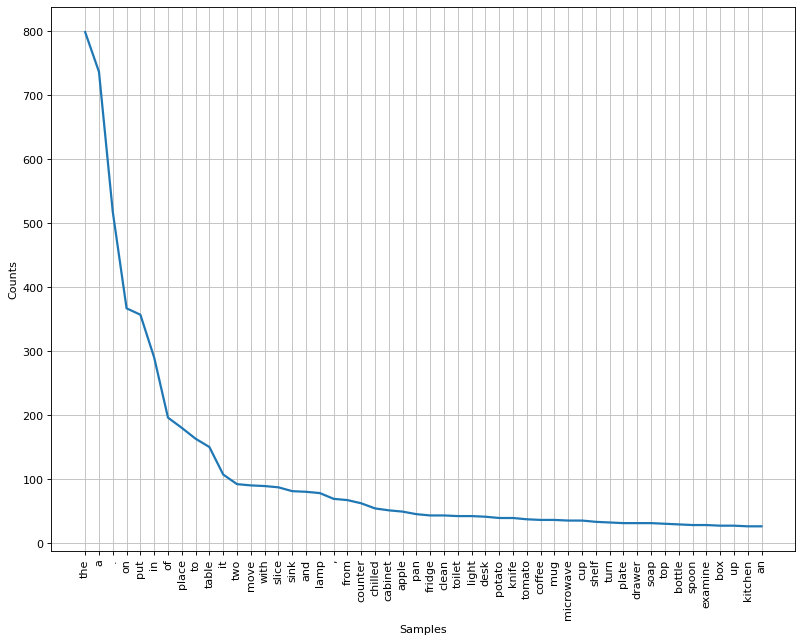

In [13]:
figure(num=None, figsize=(12, 9), dpi=80, facecolor='w', edgecolor='k')
fd = nltk.FreqDist(train_sanity_ref_tokens)
fd.plot(50,cumulative=False)

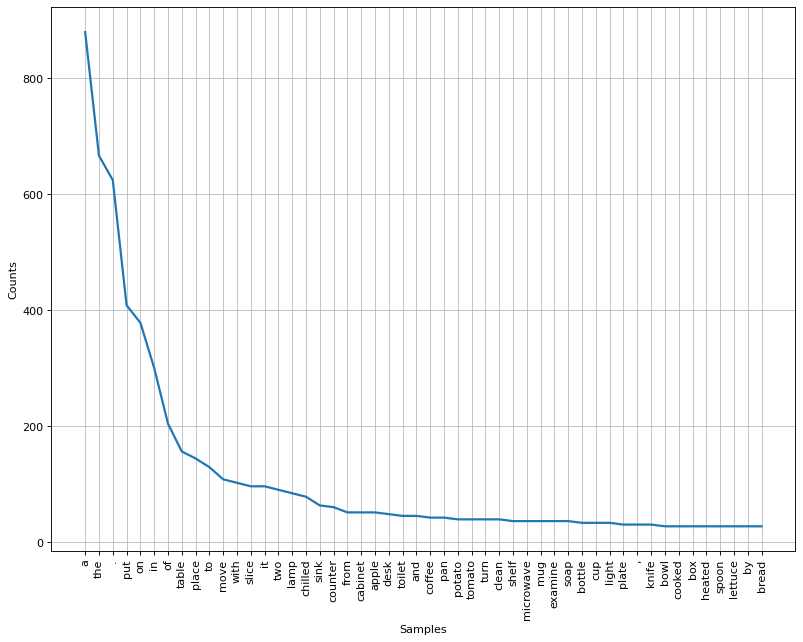

In [17]:
figure(num=None, figsize=(12, 9), dpi=80, facecolor='w', edgecolor='k')
fd = nltk.FreqDist(v1_train_sanity_p_tokens)
fd.plot(50,cumulative=False)

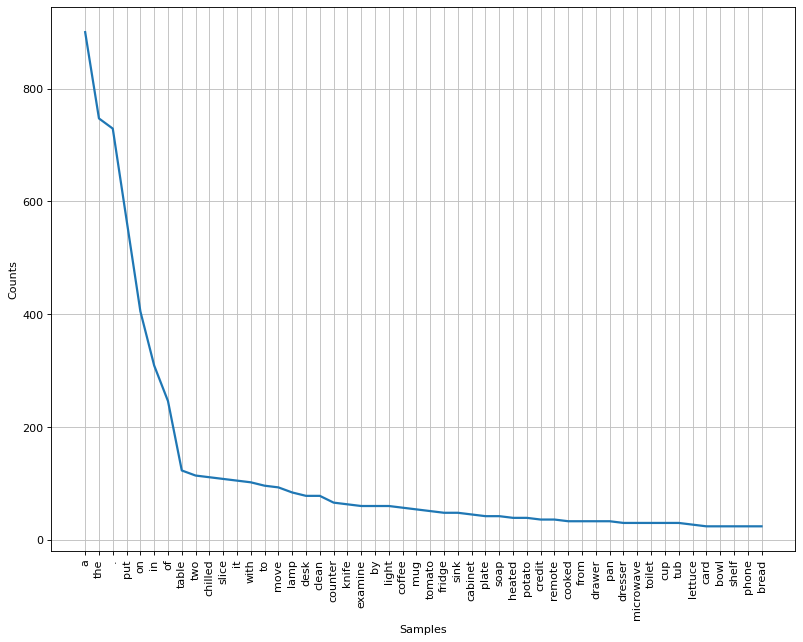

In [12]:
figure(num=None, figsize=(12, 9), dpi=80, facecolor='w', edgecolor='k')
fd = nltk.FreqDist(v0_train_sanity_p_tokens)
fd.plot(50,cumulative=False)

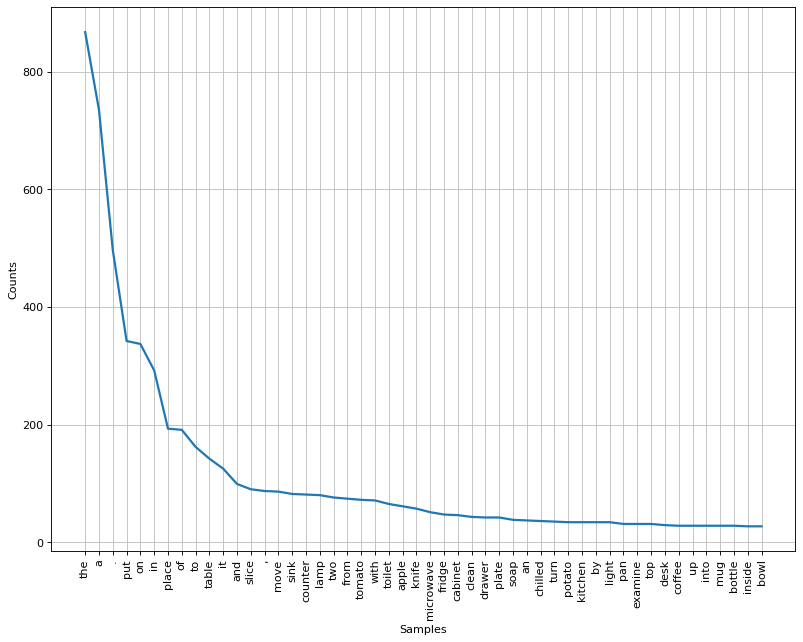

In [11]:
figure(num=None, figsize=(12, 9), dpi=80, facecolor='w', edgecolor='k')
fd = nltk.FreqDist(valid_seen_ref_tokens)
fd.plot(50,cumulative=False)

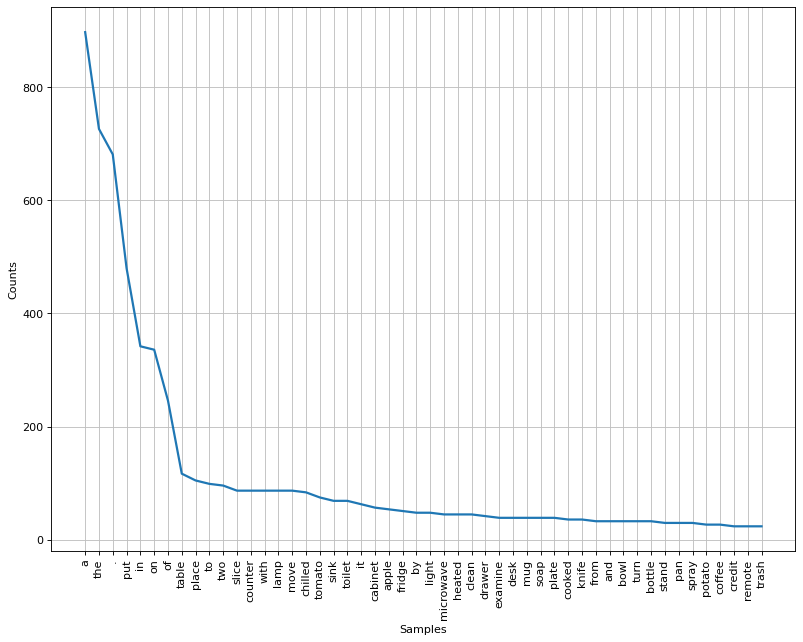

In [9]:
figure(num=None, figsize=(12, 9), dpi=80, facecolor='w', edgecolor='k')
fd = nltk.FreqDist(v1_valid_seen_p_tokens)
fd.plot(50,cumulative=False)

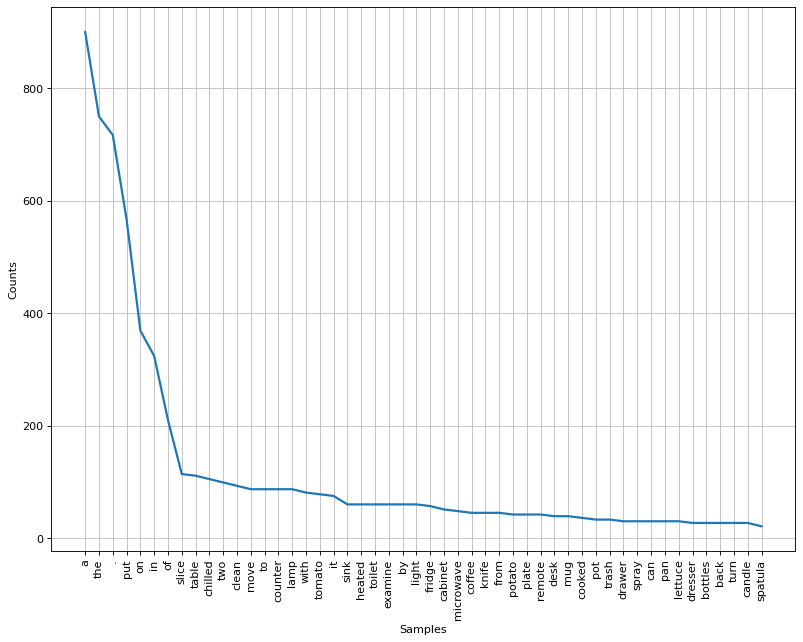

In [10]:
figure(num=None, figsize=(12, 9), dpi=80, facecolor='w', edgecolor='k')
fd = nltk.FreqDist(v0_valid_seen_p_tokens)
fd.plot(50,cumulative=False)

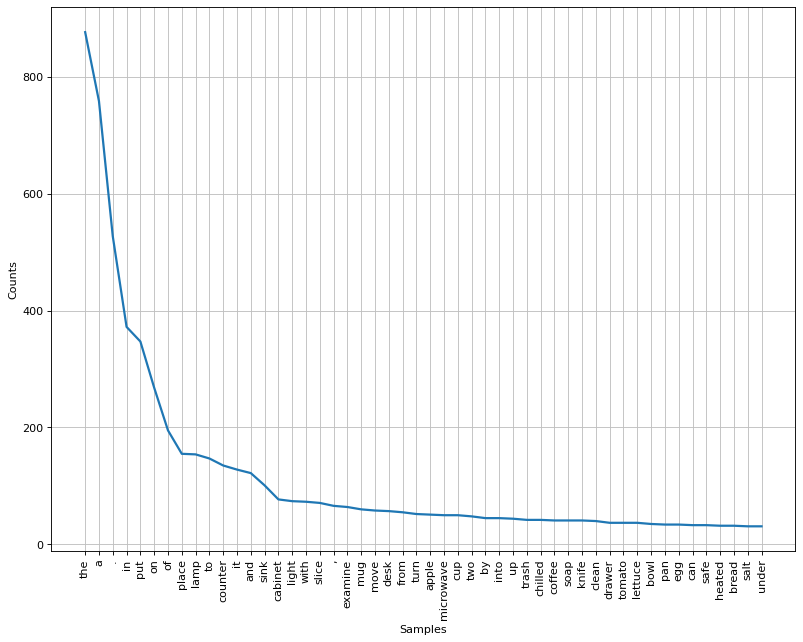

In [16]:
figure(num=None, figsize=(12, 9), dpi=80, facecolor='w', edgecolor='k')
fd = nltk.FreqDist(valid_unseen_ref_tokens)
fd.plot(50,cumulative=False)

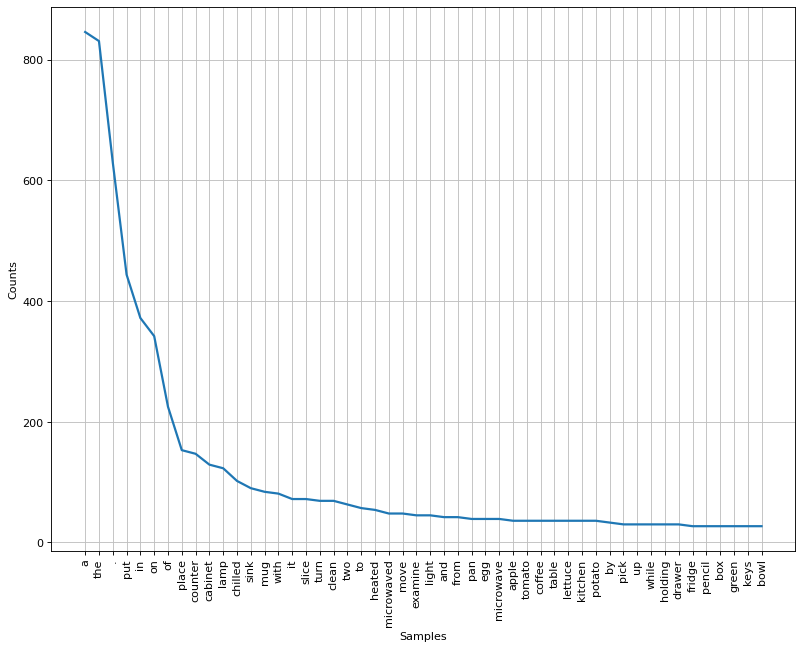

In [14]:
figure(num=None, figsize=(12, 9), dpi=80, facecolor='w', edgecolor='k')
fd = nltk.FreqDist(v1_valid_unseen_p_tokens)
fd.plot(50,cumulative=False)

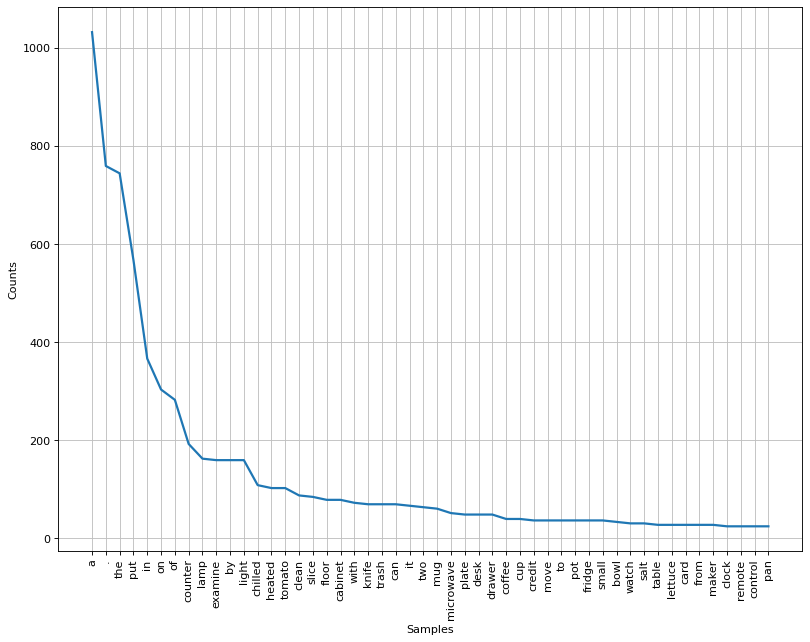

In [15]:
figure(num=None, figsize=(12, 9), dpi=80, facecolor='w', edgecolor='k')
fd = nltk.FreqDist(v0_valid_unseen_p_tokens)
fd.plot(50,cumulative=False)

## Compare word occurences

In [18]:
def compute_diff_dict(ref_vocab_normalized, p_vocab_normalized):
    diff = defaultdict(int)
    for word_type in ref_vocab_normalized:
        if word_type in p_vocab_normalized:
            diff[word_type] = ref_vocab_normalized[word_type] - p_vocab_normalized[word_type]
        else:
            diff[word_type] = ref_vocab_normalized[word_type]
    return diff

In [19]:
ref_train_sanity_vocab_normalized = {k : (v * 1.0 / sum(ref_train_sanity_vocab.values())) for (k,v) in ref_train_sanity_vocab.items()}
v1_train_sanity_p_vocab_normalized = {k : (v * 1.0 / sum(v1_train_sanity_p_vocab.values())) for (k,v) in v1_train_sanity_p_vocab.items()}
v0_train_sanity_p_vocab_normalized = {k : (v * 1.0 / sum(v0_train_sanity_p_vocab.values())) for (k,v) in v0_train_sanity_p_vocab.items()}

ref_valid_seen_vocab_normalized = {k : (v * 1.0 / sum(ref_valid_seen_vocab.values())) for (k,v) in ref_valid_seen_vocab.items()}
v1_valid_seen_p_vocab_normalized = {k : (v * 1.0 / sum(v1_valid_seen_p_vocab.values())) for (k,v) in v1_valid_seen_p_vocab.items()}
v0_valid_seen_p_vocab_normalized = {k : (v * 1.0 / sum(v0_valid_seen_p_vocab.values())) for (k,v) in v0_valid_seen_p_vocab.items()}

ref_valid_unseen_vocab_normalized = {k : (v * 1.0 / sum(ref_valid_unseen_vocab.values())) for (k,v) in ref_valid_unseen_vocab.items()}
v1_valid_unseen_p_vocab_normalized = {k : (v * 1.0 / sum(v1_valid_unseen_p_vocab.values())) for (k,v) in v1_valid_unseen_p_vocab.items()}
v0_valid_unseen_p_vocab_normalized = {k : (v * 1.0 / sum(v0_valid_unseen_p_vocab.values())) for (k,v) in v0_valid_unseen_p_vocab.items()}

In [20]:
v1_train_sanity_diff = compute_diff_dict(ref_train_sanity_vocab_normalized, v1_train_sanity_p_vocab_normalized)
v0_train_sanity_diff = compute_diff_dict(ref_train_sanity_vocab_normalized, v0_train_sanity_p_vocab_normalized)

v1_valid_seen_diff = compute_diff_dict(ref_valid_seen_vocab_normalized, v1_valid_seen_p_vocab_normalized)
v0_valid_seen_diff = compute_diff_dict(ref_valid_seen_vocab_normalized, v0_valid_seen_p_vocab_normalized)

v1_valid_unseen_diff = compute_diff_dict(ref_valid_unseen_vocab_normalized, v1_valid_unseen_p_vocab_normalized)
v0_valid_unseen_diff = compute_diff_dict(ref_valid_unseen_vocab_normalized, v0_valid_unseen_p_vocab_normalized)

In [21]:
# 
v1_train_sanity_diff_sorted = sorted([(k,v) for (k,v) in v1_train_sanity_diff.items()], key=lambda x:abs(x[1]), reverse=True)

In [22]:
def print_top_k_vocab_gap(ref_vocab_normalized, p_vocab_normalized, diff_dict, k=10):
    diff_sorted = sorted([(k,v) for (k,v) in diff_dict.items()], key=lambda x:abs(x[1]), reverse=True)
    line = '{:>12}  {:>12}  {:>12}  {:>12}'.format('word', '% in annotation', '% in predicted', 'difference')
    print(line)
    for (k,v) in diff_sorted[:k]:
        if k in p_vocab_normalized:
            line = '{:>12}  {:>12}  {:>12}  {:>12}'.format(k, round(ref_vocab_normalized[k],3), round(p_vocab_normalized[k],3), round(v,3))
        else:
            line = '{:>12}  {:>12}  {:>12}  {:>12}'.format(k, round(ref_vocab_normalized[k],3), 0.0, round(v,3))
        print(line)

In [61]:
# train_sanity V1
print_top_k_vocab_gap(ref_train_sanity_vocab_normalized, v1_train_sanity_p_vocab_normalized, v1_train_sanity_diff, k=50)

        word  % in annotation  % in predicted    difference
           a         0.098         0.123        -0.025
           .         0.069         0.087        -0.018
         the         0.106         0.093         0.013
         put         0.048         0.057        -0.009
           ,         0.009         0.004         0.005
         and         0.011         0.006         0.004
          on         0.049         0.053        -0.004
       place         0.024          0.02         0.004
     chilled         0.007         0.011        -0.004
          to         0.022         0.018         0.004
          in         0.039         0.042        -0.003
         top         0.004         0.001         0.003
        move         0.012         0.015        -0.003
          of         0.026         0.028        -0.002
        with         0.012         0.014        -0.002
        sink         0.011         0.009         0.002
      fridge         0.006         0.004         0.002
     

In [24]:
# train_sanity V0
print_top_k_vocab_gap(ref_train_sanity_vocab_normalized, v0_train_sanity_p_vocab_normalized, v0_train_sanity_diff, k=50)

        word  % in annotation  % in predicted    difference
           .         0.069         0.101        -0.032
         put         0.048         0.078        -0.031
           a         0.098         0.124        -0.026
       place         0.024         0.002         0.022
           ,         0.009           0.0         0.009
          to         0.022         0.013         0.008
     chilled         0.007         0.015        -0.008
          of         0.026         0.034        -0.008
         and         0.011         0.003         0.008
          on         0.049         0.056        -0.007
          by         0.003         0.008        -0.005
        desk         0.005         0.011        -0.005
       clean         0.006         0.011        -0.005
     examine         0.004         0.008        -0.005
        from         0.009         0.005         0.004
        sink         0.011         0.007         0.004
          in         0.039         0.043        -0.004
     

In [25]:
# valid_seen V1
print_top_k_vocab_gap(ref_valid_seen_vocab_normalized, v1_valid_seen_p_vocab_normalized, v1_valid_seen_diff, k=50)

        word  % in annotation  % in predicted    difference
           .         0.065         0.096         -0.03
           a         0.097         0.126        -0.029
         put         0.045         0.067        -0.022
         the         0.114         0.102         0.012
       place         0.025         0.015         0.011
           ,         0.011         0.001         0.011
          in         0.038         0.048         -0.01
          of         0.025         0.035        -0.009
         and         0.013         0.005         0.008
          it         0.016         0.009         0.008
          to         0.021         0.014         0.007
     chilled         0.005         0.012        -0.007
        from          0.01         0.005         0.005
          an         0.005         0.001         0.004
         two          0.01         0.013        -0.003
      heated         0.003         0.006        -0.003
     kitchen         0.004         0.001         0.003
     

In [26]:
# valid_seen V0
print_top_k_vocab_gap(ref_valid_seen_vocab_normalized, v0_valid_seen_p_vocab_normalized, v0_valid_seen_diff, k=50)

        word  % in annotation  % in predicted    difference
           .         0.065         0.102        -0.036
         put         0.045          0.08        -0.035
           a         0.097         0.128        -0.031
       place         0.025         0.002         0.024
           ,         0.011           0.0         0.011
         and         0.013         0.003          0.01
     chilled         0.005         0.015         -0.01
          to         0.021         0.012         0.009
          on         0.044         0.052        -0.008
         the         0.114         0.106         0.008
       clean         0.006         0.013        -0.008
          in         0.038         0.046        -0.008
          it         0.016         0.011         0.006
      heated         0.003         0.009        -0.005
       apple         0.008         0.003         0.005
          an         0.005           0.0         0.005
          of         0.025          0.03        -0.005
     

In [27]:
# valid_unseen V1
print_top_k_vocab_gap(ref_valid_unseen_vocab_normalized, v1_valid_unseen_p_vocab_normalized, v1_valid_unseen_diff, k=50)

        word  % in annotation  % in predicted    difference
           a         0.099         0.118         -0.02
           .         0.069         0.088         -0.02
         put         0.045         0.062        -0.017
          on         0.035         0.048        -0.013
          to         0.019         0.008         0.011
         and         0.016         0.006          0.01
     chilled         0.005         0.014        -0.009
     cabinet          0.01         0.018        -0.008
          it         0.017          0.01         0.007
          of         0.025         0.031        -0.006
  microwaved         0.001         0.007        -0.006
           ,         0.009         0.003         0.005
       clean         0.005          0.01        -0.004
         cup         0.007         0.002         0.004
        safe         0.004           0.0         0.004
       table         0.001         0.005        -0.004
         mug         0.008         0.012        -0.004
     

In [28]:
# valid_unseen V0
print_top_k_vocab_gap(ref_valid_unseen_vocab_normalized, v0_valid_unseen_p_vocab_normalized, v0_valid_unseen_diff, k=50)

        word  % in annotation  % in predicted    difference
           a         0.099          0.14        -0.041
           .         0.069         0.103        -0.034
         put         0.045         0.077        -0.032
       place          0.02           0.0          0.02
          by         0.006         0.022        -0.016
         and         0.016           0.0         0.015
          to         0.019         0.005         0.014
         the         0.114         0.101         0.013
     examine         0.008         0.022        -0.013
          of         0.025         0.038        -0.013
        sink         0.013         0.001         0.012
       light          0.01         0.022        -0.012
      heated         0.004         0.014         -0.01
     chilled         0.005         0.015        -0.009
       floor         0.002         0.011        -0.009
      tomato         0.005         0.014        -0.009
           ,         0.009           0.0         0.009
     

In [29]:
missing_vocab_v1_train_sanity = set(ref_train_sanity_vocab.keys()) - set(v1_train_sanity_p_vocab.keys())
missing_vocab_v0_train_sanity = set(ref_train_sanity_vocab.keys()) - set(v0_train_sanity_p_vocab.keys())

missing_vocab_v1_valid_seen = set(ref_valid_seen_vocab.keys()) - set(v1_valid_seen_p_vocab.keys())
missing_vocab_v0_valid_seen = set(ref_valid_seen_vocab.keys()) - set(v0_valid_seen_p_vocab.keys())

missing_vocab_v1_valid_unseen = set(ref_valid_unseen_vocab.keys()) - set(v1_valid_unseen_p_vocab.keys())
missing_vocab_v0_valid_unseen = set(ref_valid_unseen_vocab.keys()) - set(v0_valid_unseen_p_vocab.keys())

In [37]:
len(ref_valid_unseen_vocab.keys())

367

In [38]:
len(v1_valid_unseen_p_vocab.keys())

167

In [39]:
len(v0_valid_unseen_p_vocab.keys())

122

In [47]:
line = '{:>12}  {:>12}'.format('word', '% in annotation')
types = []
print(line)
for word_type in v0_valid_unseen_diff:
    if word_type in missing_vocab_v0_valid_unseen:
        types.append(word_type)
        line = '{:>12}  {:>12}'.format(word_type, ref_valid_unseen_vocab_normalized[word_type])
        print(line)
        
print(len(types))
print(len(missing_vocab_v0_valid_unseen))

        word  % in annotation
        pick  0.003386298515238343
          up  0.0057306590257879654
        cell  0.00013024225058609013
        look  0.0028653295128939827
          at  0.003256056264652253
     bedroom  0.00039072675175827037
         get  0.0007814535035165407
          an  0.0028653295128939827
        heat  0.003386298515238343
        cook  0.0011721802552748112
           ,  0.008595988538681949
       place  0.02018754884084397
        away  0.001041938004688721
     kitchen  0.0027350872623078926
      filled  0.00039072675175827037
       water  0.0011721802552748112
        left  0.001041938004688721
      wooden  0.00026048450117218026
       white  0.0013024225058609013
      inside  0.003777025266996614
        onto  0.00039072675175827037
      second  0.0005209690023443605
        cool  0.0011721802552748112
        cold  0.002995571763480073
 refrigerate  0.00013024225058609013
        that  0.0005209690023443605
          is  0.00026048450117218026
 

In [48]:
_,_,_,_,_,v1_train_sanity_n_pred_tokens,_,_,_ = preprocess_debug_data(v1_debug_train_sanity)
_,_,_,_,train_sanity_n_ref_tokens,v0_train_sanity_n_pred_tokens,train_sanity_n_subgoals,train_sanity_n_actions,_ = preprocess_debug_data(v0_debug_train_sanity)

In [49]:
_,_,_,_,_,v1_valid_seen_n_pred_tokens,_,_,_ = preprocess_debug_data(v1_debug_valid_seen)
_,_,_,_,valid_seen_n_ref_tokens,v0_valid_seen_n_pred_tokens,valid_seen_n_subgoals,valid_seen_n_actions,_ = preprocess_debug_data(v0_debug_valid_seen)

In [50]:
_,_,_,_,_,v1_valid_unseen_n_pred_tokens,_,_,_ = preprocess_debug_data(v1_debug_valid_unseen)
_,_,_,_,valid_unseen_n_ref_tokens,v0_valid_unseen_n_pred_tokens,valid_unseen_n_subgoals,valid_unseen_n_actions,_ = preprocess_debug_data(v0_debug_valid_unseen)

In [51]:
len(v0_valid_unseen_n_pred_tokens)

255

In [52]:
len(valid_unseen_n_ref_tokens)

255

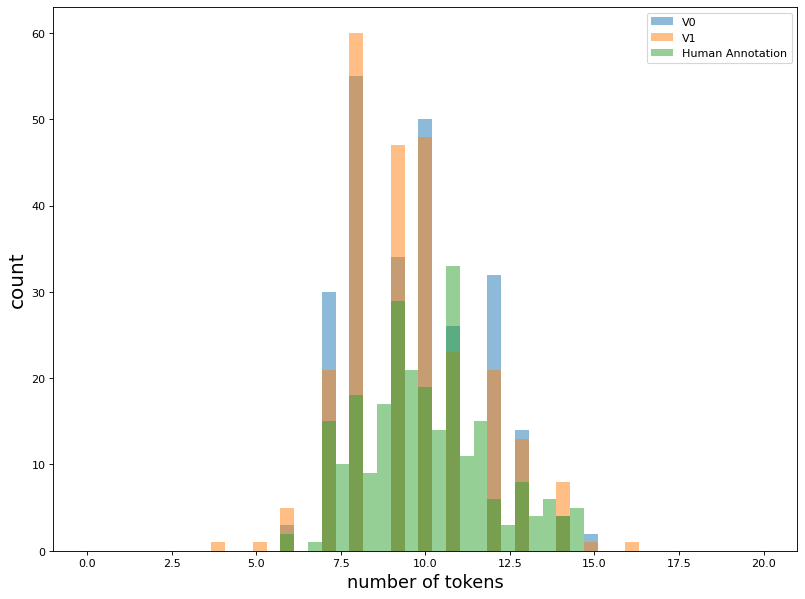

In [58]:
# Train Sanity

figure(num=None, figsize=(12, 9), dpi=80, facecolor='w', edgecolor='k')

bins = np.linspace(0, 20, 50)
plt.hist(np.array(v0_train_sanity_n_pred_tokens), bins=bins, alpha=0.5, label='V0')
plt.hist(np.array(v1_train_sanity_n_pred_tokens), bins=bins, alpha=0.5, label='V1')
plt.hist(np.array(train_sanity_n_ref_tokens), bins=bins, alpha=0.5, label='Human Annotation')
plt.ylabel('count', fontsize=18)
plt.xlabel('number of tokens', fontsize=16)
plt.legend(loc='upper right')

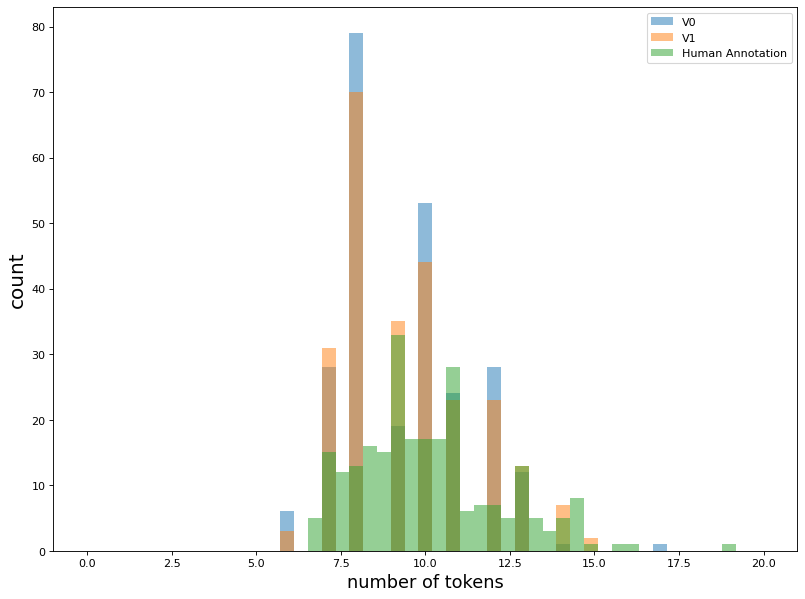

In [59]:
# Valid Seen

figure(num=None, figsize=(12, 9), dpi=80, facecolor='w', edgecolor='k')

bins = np.linspace(0, 20, 50)
plt.hist(np.array(v0_valid_seen_n_pred_tokens), bins=bins, alpha=0.5, label='V0')
plt.hist(np.array(v1_valid_seen_n_pred_tokens), bins=bins, alpha=0.5, label='V1')
plt.hist(np.array(valid_seen_n_ref_tokens), bins=bins, alpha=0.5, label='Human Annotation')
plt.ylabel('count', fontsize=18)
plt.xlabel('number of tokens', fontsize=16)
plt.legend(loc='upper right')

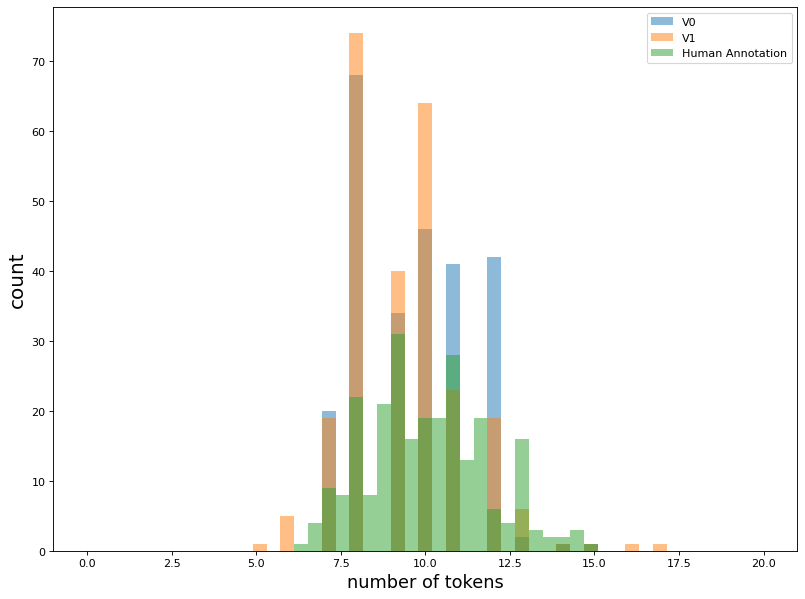

In [60]:
# Valid Unseen

figure(num=None, figsize=(12, 9), dpi=80, facecolor='w', edgecolor='k')

bins = np.linspace(0, 20, 50)
plt.hist(np.array(v0_valid_unseen_n_pred_tokens), bins=bins, alpha=0.5, label='V0')
plt.hist(np.array(v1_valid_unseen_n_pred_tokens), bins=bins, alpha=0.5, label='V1')
plt.hist(np.array(valid_unseen_n_ref_tokens), bins=bins, alpha=0.5, label='Human Annotation')
plt.ylabel('count', fontsize=18)
plt.xlabel('number of tokens', fontsize=16)
plt.legend(loc='upper right')